# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
# import quadrotor

# print("Mass    =", quadrotor.MASS)
# print("Length  =", quadrotor.LENGTH)
# print("Inertia =", quadrotor.INERTIA)
# print("Dt      =", quadrotor.DT)
# print("state size   =", quadrotor.DIM_STATE)
# print("control size =", quadrotor.DIM_CONTROL)



## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from qpsolvers import solve_qp, Problem, solve_problem
import quadrotor

def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
# quadrotor.animate_robot(state, u)

## Part 1
1. Given State dynamics:
$$\begin{align} 
\dot{p_x} &= v_x\\
\dot{v}_x &= - \frac{(u_1 + u_2) \sin \theta}{m} \\ 
\dot{p_y} &= v_y\\
\dot{v}_y &= \frac{(u_1 + u_2) \cos \theta}{m}  - g\\
\dot{\theta} &= \omega\\
\dot{\omega} &= \frac{r (u_1 - u_2)}{I} \end{align}$$

After Discretizing the state dynamics and doing Taylor Series Expansion to get a linear approximation
$$\begin{align}
    \delta p_{x_{n+1}} &= \delta p_{x_n} + \delta t \delta v_{x_n} \\
    \delta v_{x_{n+1}} &= \delta v_{x_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - \delta t (\delta u_{1_n} +  \delta u_{2_n} )\frac{\sin \theta_n}{m}\\
    \delta p_{y_{n+1}} &= \delta p_{y_n} + \delta t \delta v_{y_n} \\
    \delta v_{y_{n+1}} &= \delta v_{y_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} + \delta t (\delta u_{1_n} + \delta u_{2_n}) \frac{\cos \theta_n}{m}\\
    \delta \theta_{n+1} &= \delta \theta_{n} + \delta t \delta \omega_n \\
    \delta \omega_{n+1} &= \delta \omega_{n} + \delta t \frac{L(\delta u_{1_n} - \delta u_{2_n})}{I}
\end{align}$$

In [3]:
class Optimization:
    # initialize the variables from the module quadrotor
    def __init__(self, m, l, I, dt, g, xdim, udim):
        # Initialize the variables from the quadrotor module
        self.m = m
        self.l = l
        self.I = I
        self.dt = dt
        self.xdim = xdim
        self.udim = udim
        self.g = g
        

    # define the quadrotor dynamics
    def quadrotor_dynamics(self, x_init, y, N=100):
        nvar = self.xdim + self.udim
        # Print the shapes
        # print(f"Total shape of y: {y.shape}")
        # print(f"Total shape of x_init: {x_init.shape}")

        # Define the placeholders for A and b
        A = np.zeros((6 * N, nvar * N))
        b = np.zeros(6 * N)

        # Define the initial state constraints
        A[:6, :] = np.eye(6, nvar * N)
        b[:6] = x_init - y[:6]

        # Define the constraints for the rest of the time steps
        '''
        Check again the range of the loop N or N-1 
        '''
        for t in range(N-1):
            # Propogate the indices
            i = t * nvar
            n = i
            n1 = i + nvar

            # Assign the variables at time step t
            px = y[n]
            vx = y[n + 1]
            py = y[n + 2]
            vy = y[n + 3]
            theta = y[n + 4]
            omega = y[n + 5]
            u1 = y[n + 6]
            u2 = y[n + 7]

            # Assign the variables at time step t+1
            px_1 = y[n1]
            vx_1 = y[n1 + 1]
            py_1 = y[n1 + 2]
            vy_1 = y[n1 + 3]
            theta_1 = y[n1 + 4]
            omega_1 = y[n1 + 5]

            # Position x constraint
            A[6 * (t+1), n] = 1
            A[6 * (t+1), n + 1] = self.dt
            A[6 * (t+1), n1] = -1
            b[6 * (t+1)] = px + (self.dt * vx) - px_1

            # Velocity x constraint
            A[6 * (t+1) + 1, n + 1] = 1
            A[6 * (t+1) + 1, n + 4] = -self.dt * ((u1 + u2) * np.cos(theta) / self.m)
            A[6 * (t+1) + 1, n + 6] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n + 7] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n1 + 1] = -1
            b[6 * (t+1) + 1] = vx - (self.dt * (u1 + u2) * np.sin(theta) / self.m) - vx_1

            # Position y constraint
            A[6 * (t+1) + 2, n + 2] = 1
            A[6 * (t+1) + 2, n + 3] = self.dt
            A[6 * (t+1) + 2, n1 + 2] = -1
            b[6 * (t+1) + 2] = py + self.dt * vy - py_1
            
            # Velocity y constraint
            A[6 * (t+1) + 3, n + 3] = 1
            A[6 * (t+1) + 3, n + 4] = -self.dt * ((u1 + u2) * np.sin(theta) / self.m)
            A[6 * (t+1) + 3, n + 6] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n + 7] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n1 + 3] = -1
            b[6 * (t+1) + 3] = vy + self.dt * (((u1 + u2) * np.cos(theta) / self.m) - 9.81) - vy_1

            # Angle theta constraint
            A[6 * (t+1) + 4, n + 4] = 1
            A[6 * (t+1) + 4, n + 5] = self.dt
            A[6 * (t+1) + 4, n1 + 4] = -1
            b[6 * (t+1) + 4] = theta + self.dt * omega - theta_1

            # Angular velocity omega constraint
            A[6 * (t+1) + 5, n + 5] = 1
            A[6 * (t+1) + 5, n + 6] = self.dt * self.l / self.I
            A[6 * (t+1) + 5, n + 7] = -self.dt * self.l / self.I
            A[6 * (t+1) + 5, n1 + 5] = -1
            b[6 * (t+1) + 5] = omega + self.dt * self.l * (u1 - u2) / self.I - omega_1

        # # Print shapes of A and b
        # print(f"Shape of A: {A.shape}")
        # print(f"Shape of b: {b.shape}")
        return A, b

    def circle_traj_gen(self, k, N):
        des_x = np.cos(2 * np.pi * k / N)
        # des_x = 0
        des_y = 1 + np.sin(-np.pi/2 + (2 * np.pi * k / N))

        if k < N/5:
            des_theta = 0
        elif N/5 <= k < 2 * N/5:
            des_theta = np.pi/2
        elif 2 * N/5 <= k < 3 * N/5:
            des_theta = np.pi
        elif 3 * N/5 <= k < 4 * N/5:
            des_theta = 2 * np.pi
        else:
            des_theta = 2 * np.pi

        return des_x, des_y, des_theta
    
    

    
    def cost_function(self, y, x_init, N):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        y = y.flatten()
        x_init = x_init.flatten()
        mini_Q = np.diag([10, 1, 10, 1, 10, 1])
        mini_R = np.diag([0.1, 0.1])

        # Initialize the cost for N states and N-1 controls
        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # Loop over the horizon
        for k in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(k=k, N=N)
            q[(nvar * k):(nvar * k + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        q = q.reshape(-1, 1).flatten()
        cost = 0.5 * (y.T @ P @ y) + (q.T @ y)

        # Sanity Check for the shapes
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")
        # print(f"Shape of y: {y.shape}")
        # print(f"Shape of x_init: {x_init.shape}")

        return cost

    

    def grad_cost(self, x_init, y, N):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        x_init = x_init.flatten()
        y = y.flatten()

        mini_Q = np.diag([10, 1, 10, 1, 10, 1])
        mini_R = np.diag([0.1, 0.1])

        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # # Print the shapes of P and q
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")

        for k in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(k=k, N=N)
            q[(nvar * k):(nvar * k + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        grad_f = P @ y + q

        return grad_f
    
    def hess_cost(self, N):
        mini_Q = np.diag([10, 1, 10, 1, 10, 1])
        mini_R = np.diag([0.1, 0.1])

        cost_hess = block_diag(*([mini_Q, mini_R] * N))
        assert cost_hess.shape[0] == cost_hess.shape[1]

        return cost_hess
    
    def equality_cons(self, y, N):
        # Number of variavles in the state and control
        nvar = self.xdim + self.udim
        y = y.flatten()

        mini_G = np.array([[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, -1]])
        
        G = block_diag(*([mini_G] * N))
        h = np.zeros((4 * N)).flatten()

        for i in range(N):
            u1 = y[(nvar * i) + 6]
            u2 = y[(nvar * i) + 7]

            h[((i * self.udim * 2))] = 10 - u1
            h[((i * self.udim * 2) + 1)] = -u1
            h[((i * self.udim * 2) + 2)] = 10 - u2
            h[((i * self.udim * 2) + 3)] = u2

        return G, h
    

    def KKT_Solver(self, x_init, y, N):
        A, b = self.quadrotor_dynamics(x_init, y, N)
        G, h = self.equality_cons(y, N)
        
        kkt_problem = Problem(P = csr_matrix(self.hess_cost(N)),q = self.grad_cost(x_init, y, N), A = csr_matrix(A), b = -b, G = csr_matrix(G), h = h)
        kkt_sol = solve_problem(problem=kkt_problem, solver="cvxopt")
            
        return kkt_sol
    
    def constaint_violation(self, x_init, y, N):
        nvar = self.xdim + self.udim
        y = np.asarray(y, dtype=np.float64).flatten()
        x_init = np.asarray(x_init, dtype=np.float64).flatten()

        A_prime, b_prime = self.quadrotor_dynamics(x_init, y, N)
        total_violation = np.sum(np.abs(b_prime))
        inequality_violation = 0

        for i in range(N):
            u1 = y[(nvar * i) + 6]
            u2 = y[(nvar * i) + 7]
            if u1 > 10:
                total_violation += np.abs(u1 - 10)
            elif u1 < 0:
                total_violation += np.abs(u1)

            if u2 > 10:
                total_violation += np.abs(u2 - 10)
            elif u2 < 0:
                total_violation += np.abs(u2)

        return total_violation + inequality_violation

    def line_search(self, x_init, est_y, N, alpha=0.5, rho=0.1, tol=1e-4, iterations=1000):
        x_init = x_init.flatten()
        est_y = est_y.flatten()

        least_violation = np.inf
        optimal_cost = np.inf
        cost_list = []
        violation_list = []
        alpha_list = []

        for i in range(iterations):
            alpha = 1  
            rho = 0.1
            converged = False
            sol = self.KKT_Solver(x_init, est_y, N)
            pk = sol.x

            # Gradient norm for debugging
            grad_norm = np.linalg.norm(self.grad_cost(x_init, est_y, N))
            print(f"Iteration {i+1}: ||grad|| = {grad_norm}, pk norm = {np.linalg.norm(pk)}")

            while True:
                # Compute new candidate solution
                new_y = est_y + alpha * pk
                cost = self.cost_function(x_init=x_init, y=new_y, N=N)
                violation = self.constaint_violation(x_init=x_init, y=new_y, N=N)

                # Check line search conditions
                if cost <= optimal_cost + tol * alpha * np.dot(self.grad_cost(x_init, est_y, N), pk) and violation <= least_violation + tol:
                    break  # Accept step
                alpha *= rho
                if alpha < 1e-6:
                    print("Alpha too small not converged")
                    converged = True
                    break
            
            if converged:
                break

            # Update optimal values
            est_y = est_y + alpha * pk
            least_violation = violation
            optimal_cost = cost

            # Track progress
            alpha_list.append(alpha)
            cost_list.append(optimal_cost)
            violation_list.append(least_violation)

            print(f"At iteration {i+1}: Cost = {np.round(optimal_cost, 4)}, Violation = {np.round(least_violation, 4)}, Alpha = {alpha}")

            # Termination check
            if least_violation < tol and np.linalg.norm(pk) < tol:
                print("Converged to solution.")
                break

        est_y = est_y.reshape(-1, 8)
        x = est_y[:, :6].T
        u = est_y[:, 6:].T

        return x, u

    





In [4]:
# Initialize the optimization class
opt = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
N = 100
nvar = quadrotor.DIM_STATE + quadrotor.DIM_CONTROL
# Initialize the variables
x_init = np.array([0, 0, 0, 0, 0, 0])
y = np.zeros(nvar * N)
x, u = opt.line_search(x_init, y, N)

Iteration 1: ||grad|| = 450.0974132564562, pk norm = 60.255866986676864
At iteration 1: Cost = -9439.3863, Violation = 37.0868, Alpha = 1
Iteration 2: ||grad|| = 91.70106975606734, pk norm = 730.6607468871167
Alpha too small not converged


In [5]:
quadrotor.animate_robot(x, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXzxtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EeFliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eIgcgRrmpCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBlAseAUmvZqKpu9J0UA829zMImH1wY7JgiAlGaqiSsbOeCBpzUiKqviMGkTF4PHYE9BQZMjL1Z
1u88kOI/LVqgCtMLuXwmGV+iOmWbVrTfDUn7BuvemqUrhq1XOil/WqG5z7kTxMdvZ7fIw/6mBwE+
CPX6WoIHa5tmpOZyedSLwKqPh/fsxLuOlr/1DzH7JLzepKa5qr61rGtYYhkKBDXfCLN7K42t0DBE
tjz/0t8yFL+PP7md5eiPK4YsvcGw+NTdfuI51AAfZtLmiMvNom67lDvhx7/u8WWl0DJt4YF3tLMX
mMAEWP9qAJPv/z4P5X183SchxzRqtJoOjzxQgs5fKzZfwy8eP9JIT1n95eqf9wiamX6OjqwG+i4Q
khk+FJ2fGorY0jWTOZuC2mvReTwXrRTm0fIVoPP2nLHv1UQgNppwqF+QdsKmz19Nl1kbiB99ZKqA
7BQYlYIhcizuiVN4S8ZUmnAIe5Z9ZvANGDDWdDwGaEgr73l0b8WAzBYsCx9QAnUyi67glxFjx9eZ
UKFtQtIruj1rpGeS5rGzKEiY5WuxRYU/WF5f3jTYdy8ovzR0ULbXDRoniuU+z8wSi8rwG8hvzxil
KeF7BnCOaeRKp055m5/7FzgBlJzXx5ChClGCxXy/nEi28+yKOqyfjDDa36LWd4Zjmxzb4w7pJcJP
+o3+9GK3qRv1goiswT7ghSIXfL5IrXu3O1PwuLt6tggJLyWGqw27SR8hUUx68MEz3rVlAY7WzPxR
gj4W3PQ2ZuOugTJfCMO2A/Jsg2xY8HkgkJY2GcRo7emGKI4PH+Al4+s938XrBo2CQnj1LQO7h+tl
UhOLCUJFt1Jqcpk7KcQQF4n0TqADgcd0/sKprNn4ZI4LOoCrcYD00vLKWUBmByhF20QQrYbd7p8e
wbeudKfoVYMrJLJ/u2XZWAF2TA3Ohol2VZYrQdfRysalySk2rUPWt4Wzg4JYtT+q9XJi0nXlHgSl
oqUzzBOSsRZl8IY6Qp/mOz/r7fX3VoZml2D0+k5YRU15FbwURYPd4EUDOQo8O3yfrqWYfyolUS/B
ezv9aM+mNrLDDiByM2uOAgJCICIzRUBGqhTkF8yt0ArNXXnB6Zz3SJ6gqUFJQYY4d1efuJ4iLeAA
AAMAcXbfzx6FJfcl25JUn6/yGwsDOeODyOCEgVvbrbiFnbf/EL65Spl5P1sw6bJ78y+9XxAge5PT
lYygqv7mXb5ESSBnZ9qz4

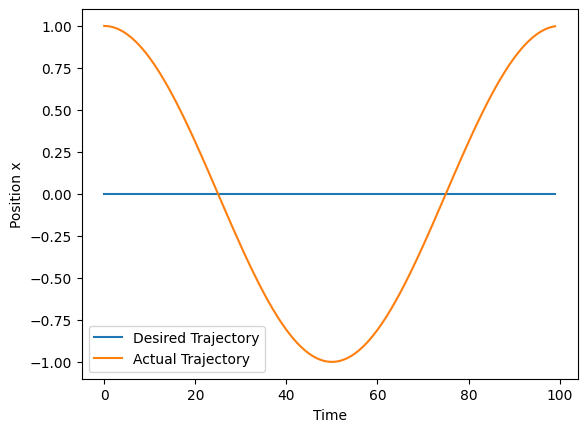

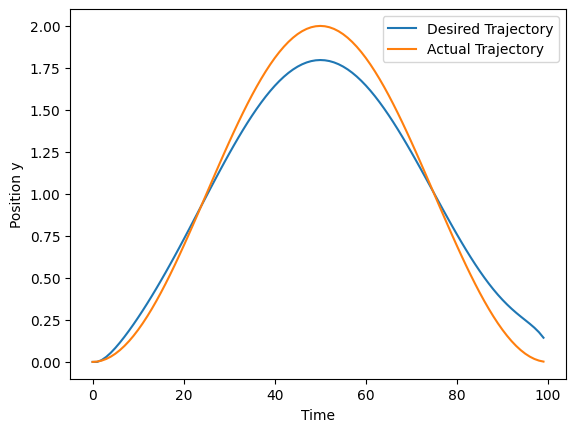

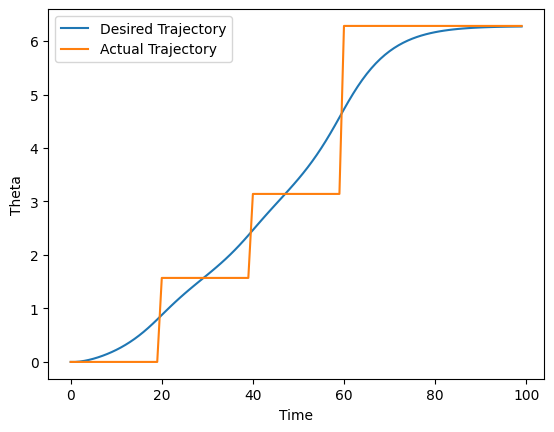

In [6]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.circle_traj_gen(i, N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(x[0, :], label="Desired Trajectory")
plt.plot(x_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(x[2, :], label="Desired Trajectory")
plt.plot(y_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(x[4, :], label="Desired Trajectory")
plt.plot(theta_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()



